# **Cryptography Final Project**
# Image encryption based on elliptic curve cryptosystem

Implement the algorithm proposed in the paper:
https://www.researchgate.net/publication/347887297_Image_encryption_based_on_elliptic_curve_cryptosystem

### Download images

In [ ]:
# download
!gdown --id 119mamKgAFu1696WzMcAT1akuDM5WCF5Z -O imgs.zip

# unzip
!unzip ./imgs.zip
!rm ./imgs.zip

Downloading...
From: https://drive.google.com/uc?id=119mamKgAFu1696WzMcAT1akuDM5WCF5Z
To: /content/imgs.zip
100% 1.16M/1.16M [00:00<00:00, 34.2MB/s]
Archive:  ./imgs.zip
   creating: imgs/
  inflating: imgs/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/imgs/
  inflating: __MACOSX/imgs/._.DS_Store  
  inflating: imgs/01.png             
  inflating: __MACOSX/imgs/._01.png  
  inflating: imgs/03.png             
  inflating: __MACOSX/imgs/._03.png  
  inflating: imgs/02.png             
  inflating: __MACOSX/imgs/._02.png  
  inflating: imgs/04.png             
  inflating: __MACOSX/imgs/._04.png  


### Import packages

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

### Global settings

In [ ]:
import os
import glob

work_dir = '.' # directory for storing images
imgs_dir = os.path.join(work_dir,'imgs')
encrypted_dir = os.path.join(work_dir,'encrypted_dir')  
decrypted_dir = os.path.join(work_dir,'decrypted_dir')  
encrypted_CBC_dir = os.path.join(work_dir,'encrypted_CBC_dir')  
decrypted_CBC_dir = os.path.join(work_dir,'decrypted_CBC_dir')  

### Some utility functions

In [ ]:
# 求Hilbert Matrix在Fp域的inverse :
def get_inverse_hilmat(value, p):
    for i in range(1, p):
        if (i * value) % p == 1:
            return i
    return p

#創造 Hilbert Matrix:
def hilmat(a, b):
    H = [[1 / (i + j + 1) for j in range(b)] for i in range(a)]
    return np.array(H)


#創造 Hilbert Matrix mod 2n-1 :(右下角的元素為2n-1)
def hilmat_mod(a,b):
    H = [[get_inverse_hilmat(i + j + 1 , 2*a-1) for j in range(b)] for i in range(a)]
    return np.array(H)

### ECC 

In [ ]:
import collections

def inv(n, q):
    """div on PN modulo a/b mod q as a * inv(b, q) mod q
    >>> assert n * inv(n, q) % q == 1
    """
    # n*inv % q = 1 => n*inv = q*m + 1 => n*inv + q*-m = 1
    # => egcd(n, q) = (inv, -m, 1) => inv = egcd(n, q)[0] (mod q)
    return egcd(n, q)[0] % q
    #[ref] naive implementation in O(q)
    #for i in range(q):
    #    if (n * i) % q == 1:
    #        return i


def egcd(a, b):
    """use extended eculidian algorithm to find inv in O(log n)
    returns: (s, t, gcd) as a*s + b*t == gcd, 
    >>> s, t, gcd = egcd(a, b)
    >>> assert a % gcd == 0 and b % gcd == 0
    >>> assert a * s + b * t == gcd
    """
    s0, s1, t0, t1 = 1, 0, 0, 1
    while b > 0:
        q, r = divmod(a, b)
        a, b = b, r
        s0, s1, t0, t1 = s1, s0 - q * s1, t1, t0 - q * t1
        pass
    return s0, t0, a


def sqrt(n, q):
    """sqrt on PN modulo: returns two numbers or exception if not exist
    >>> assert (sqrt(n, q)[0] ** 2) % q == n
    >>> assert (sqrt(n, q)[1] ** 2) % q == n
    """
    assert n < q
    for i in range(1, q):
        if i * i % q == n:
            return (i, q - i)
        pass
    raise Exception("not found")

    
Coord = collections.namedtuple("Coord", ["x", "y"])

class EC(object):
    """System of Elliptic Curve"""
    def __init__(self, a, b, q):
        """elliptic curve as: (y**2 = x**3 + a * x + b) mod q
        - a, b: params of curve formula
        - q: prime number
        """
        assert 0 < a and a < q and 0 < b and b < q and q > 2
        assert (4 * (a ** 3) + 27 * (b ** 2))  % q != 0
        self.a = a
        self.b = b
        self.q = q
        # just as unique ZERO value representation for "add": (not on curve)
        self.zero = Coord(0, 0)

    def is_valid(self, p):
        if p == self.zero: return True
        l = (p.y ** 2) % self.q
        r = ((p.x ** 3) + self.a * p.x + self.b) % self.q
        return l == r

    def at(self, x):
        """find points on curve at x
        - x: int < q
        - returns: ((x, y), (x,-y)) or not found exception
        >>> a, ma = ec.at(x)
        >>> assert a.x == ma.x and a.x == x
        >>> assert a.x == ma.x and a.x == x
        >>> assert ec.neg(a) == ma
        >>> assert ec.is_valid(a) and ec.is_valid(ma)
        """
        assert x < self.q
        ysq = (x ** 3 + self.a * x + self.b) % self.q
        y, my = sqrt(ysq, self.q)
        return Coord(x, y), Coord(x, my)

    def neg(self, p):
        """negate p
        >>> assert ec.is_valid(ec.neg(p))
        """
        return Coord(p.x, -p.y % self.q)

    def add(self, p1, p2):
        """<add> of elliptic curve: negate of 3rd cross point of (p1,p2) line
        >>> d = ec.add(a, b)
        >>> assert ec.is_valid(d)
        >>> assert ec.add(d, ec.neg(b)) == a
        >>> assert ec.add(a, ec.neg(a)) == ec.zero
        >>> assert ec.add(a, b) == ec.add(b, a)
        >>> assert ec.add(a, ec.add(b, c)) == ec.add(ec.add(a, b), c)
        """
        if p1 == self.zero: return p2
        if p2 == self.zero: return p1
        if p1.x == p2.x and (p1.y != p2.y or p1.y == 0):
            # p1 + -p1 == 0
            return self.zero
        if p1.x == p2.x:
            # p1 + p1: use tangent line of p1 as (p1,p1) line
            l = (3 * p1.x * p1.x + self.a) * inv(2 * p1.y, self.q) % self.q
            pass
        else:
            l = (p2.y - p1.y) * inv(p2.x - p1.x, self.q) % self.q
            pass
        x = (l * l - p1.x - p2.x) % self.q
        y = (l * (p1.x - x) - p1.y) % self.q
        return Coord(x, y)

    def mul(self, p, n):
        """n times <mul> of elliptic curve
        >>> m = ec.mul(p, n)
        >>> assert ec.is_valid(m)
        >>> assert ec.mul(p, 0) == ec.zero
        """
        r = self.zero
        m2 = p
        # O(log2(n)) add
        while n > 0:
            if n & 1 == 1:
                r = self.add(r, m2)
                pass
            n, m2 = n >> 1, self.add(m2, m2)
            pass
        # [ref] O(n) add
        #for i in range(n):
        #    r = self.add(r, p)
        #    pass
        return r

    def order(self, g):
        """order of point g
        >>> o = ec.order(g)
        >>> assert ec.is_valid(a) and ec.mul(a, o) == ec.zero
        >>> assert o <= ec.q
        """
        assert self.is_valid(g) and g != self.zero
        for i in range(1, self.q + 1):
            if self.mul(g, i) == self.zero:
                return i
        raise Exception("Invalid order")

### **Case 1**
### Step 1: “Generating of keys”
The domain parameters for E_37(1, 3) are {a, b, P, G} = {1, 3, 37, (0, 15)}.

In [ ]:
# initialize Eliptic Curve E_37(1, 3): y^2 = x^3 + x + 3 mod 37
a, b, p = 1, 3, 37
ECC = EC(a, b, p)

# Initialize 2 by 2 Identity matrix and Hilbert Matrix

I = np.array([[1, 0],
              [0, 1]])
Hilbert22 = hilmat_mod(2,2) 

# Choose G = (0,15) as generating point
G = Coord(0,15)

# party A's private key
nA = 11
# calculate A's public key P_A = nA * G = (3,25)
P_A = ECC.mul(G,nA)

# party B's private key
nB = 13
# calculate A's public key P_A = nA * G 
P_B = ECC.mul(G,nB)

# party A and party B now can compute K = nA * P_B = nB * P_A = (26,17) = (x,y)
K = ECC.mul(P_B, nA)

# computes 𝐾1 = 𝑥. 𝐺 = 26(0,15) = (26,17) = (𝑘11, 𝑘12)
# computes 𝐾2 = 𝑦. 𝐺 = 17(0,15) = (19,31) = (𝑘21, 𝑘22)
K1 = ECC.mul(G, K.x)
K2 = ECC.mul(G, K.y)
K11 = np.array([[K1.x, K1.y],
                [K2.x, K2.y]])
K11 += Hilbert22
K12 = (I - K11) % 256
K21 = (I + K11) % 256
K22 = -K11 % 256
Km = np.bmat([[K11,K12], 
              [K21,K22]])
print("The self invertible key matrix Km has been constructed.\n", Km)

The self invertible key matrix Km has been constructed.
 [[ 27  19 230 237]
 [ 21  34 235 223]
 [ 28  19 229 237]
 [ 21  35 235 222]]


### Step 2: “Encryption by party 𝐴”
Separates the pixel values of image into blocks of size four, and reconstructs the ciphered image from the values of 𝐶𝑖

In [ ]:
def encrypt(img, Km, index):
    img = np.array(img)
    S = img.shape
    h, w , c = S[0], S[1], S[2] # img_size = Height * Width * Channel
    img_encrypted = np.zeros([h*w, c])

    # split img into blocks of size four
    img = img.reshape(h*w, c)
    num_block = h*w // 4 # number of blocks per channel
    
    # encryption
    for i in range(c):
        for block in range(num_block):
            img_encrypted[4*block:4*(block+1), i] = np.matmul(Km, img[4*block:4*(block+1), i]) % 256
    
    img_encrypted = img_encrypted.reshape(h, w, c)
    img_encrypted = Image.fromarray(np.uint8(img_encrypted))
    
    print(f"Image0{index+1} has been encrypted successfully.")
    plt.imshow(img_encrypted)
    
    return img_encrypted

Load images and resize the width to multiple of 4

In [ ]:
# Load image

imgs = []
for k in sorted(glob.glob((os.path.join(imgs_dir,'*.png')))):
    im = Image.open(k).convert('RGB')
    imgs.append(im)

for index in range(len(imgs)):
    # resize width to multiple of 4
    S = np.array(imgs[index]).shape
    height, width = S[0], S[1]
    imgs[index] = imgs[index].resize((width - width % 4, height)) # width * height
    print(f'The size of image0{index+1} is {np.array(imgs[index]).shape}')

The size of image01 is (512, 508, 3)
The size of image02 is (316, 316, 3)
The size of image03 is (641, 424, 3)
The size of image04 is (1345, 1048, 3)


Image01 has been encrypted successfully.
Image02 has been encrypted successfully.
Image03 has been encrypted successfully.
Image04 has been encrypted successfully.
The last sample has been shown below.


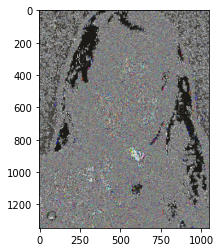

In [ ]:
# encrypt and store the result

if os.path.exists(encrypted_dir) is not True:
    os.mkdir(encrypted_dir)
encrypted_imgs = []

for index, img in enumerate(imgs):
    encrypted = encrypt(img, Km, index)
    encrypted_imgs.append(encrypted)
    encrypted.save(os.path.join(encrypted_dir,f'0{index+1}.png'))
print("The last sample has been shown below.")

### Step 3: “Decryption by party B”

In [ ]:
from sympy import Matrix # To calculate matrix inverse mod p

def decrypt(img, Km, index, selfInvert=True):
    
    Km_inv = np.array(Matrix(Km).inv_mod(256), dtype='uint8') if not selfInvert else Km    
    img = np.array(img)
    S = img.shape
    h, w , c = S[0], S[1], S[2] # img = Height * Width * Channel
    img_decrypted = np.zeros([h*w, c])
    
    # split img into blocks of size four 
    img = img.reshape(h*w, c)
    num_block = h*w // 4 # number of blocks per channel
    
    # decryption
    for i in range(c):
        for block in range(num_block):
            img_decrypted[4*block:4*(block+1), i] = np.matmul(Km_inv, img[4*block:4*(block+1), i]) % 256
            
    img_decrypted = img_decrypted.reshape(h, w, c)
    img_decrypted = Image.fromarray(np.uint8(img_decrypted))
    
    print(f"Image0{index+1} has been decrypted successfully.")
    plt.imshow(img_decrypted)
    
    return img_decrypted        

Image01 has been decrypted successfully.
Image02 has been decrypted successfully.
Image03 has been decrypted successfully.
Image04 has been decrypted successfully.
The last sample has been shown below.


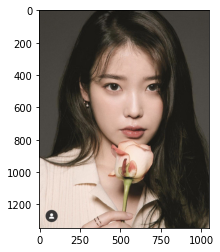

In [ ]:
# Decrypt and store the result
if os.path.exists(decrypted_dir) is not True:
    os.mkdir(decrypted_dir)

decrypted_imgs = []
    
for index, img in enumerate(encrypted_imgs):
    decrypted = decrypt(img, Km, index)
    decrypted_imgs.append(decrypted)
    decrypted.save(os.path.join(decrypted_dir,f'0{index+1}.png'))
print("The last sample has been shown below.")

### Visualization

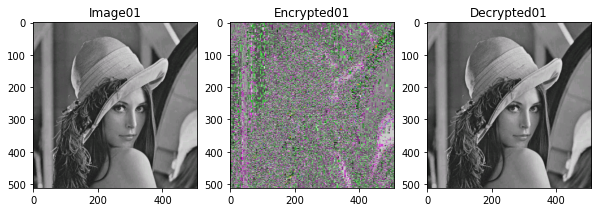

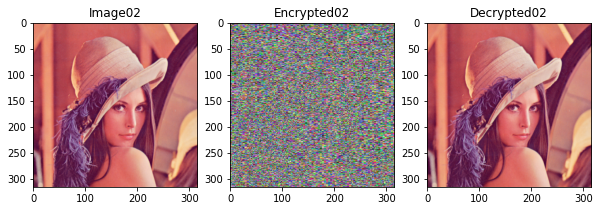

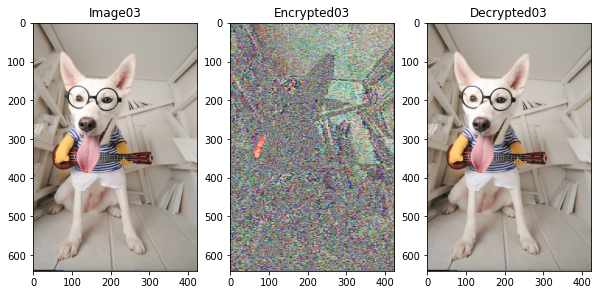

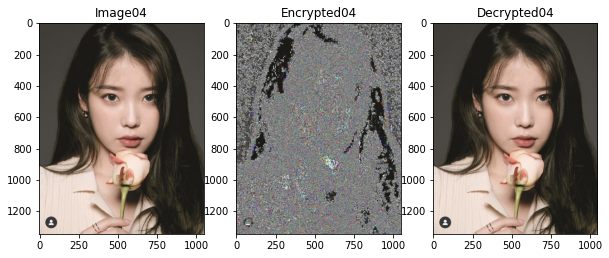

In [ ]:
def visualization(imgs, encrypted_imgs, decrypted_imgs):
    
    for index in range(len(imgs)):
        names = [f'Image0{index+1}', f"Encrypted0{index+1}", f"Decrypted0{index+1}"]
        imgs_show = [imgs[index], encrypted_imgs[index], decrypted_imgs[index]]
        plt.figure(figsize=(10, 20))
        for i in range(3):
            plt.subplot(1,3,i+1)
            im = imgs_show[i]
            plt.title(names[i])
            plt.imshow(im)

visualization(imgs, encrypted_imgs, decrypted_imgs)

## Security Analysis

### PSNR

In [ ]:
def PSNR(img1, img2):
    img1_array = np.array(img1)
    img2_array = np.array(img2)

    # if not devided by 1, the dtype=uint8 and thus the diff may be wrong
    # e.g. 200 - 225 = -25, but it will output 230 if dtype=uint8
    mse = np.mean((img1_array/1 - img2_array/1)** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

names = ['Lena_gray', 'Lena_color', 'Dog', 'IU']

print("The PSNR between images and cipher images are as follows")
for id, name in enumerate(names):
    img_original = imgs[id]
    img_encrypted = encrypted_imgs[id]
    print(f"ID: {id+1} | Name: {name} | PSNR: %.3f" % PSNR(img_original,img_encrypted))

The PSNR between images and cipher images are as follows
ID: 1 | Name: Lena_gray | PSNR: 9.847
ID: 2 | Name: Lena_color | PSNR: 8.698
ID: 3 | Name: Dog | PSNR: 9.695
ID: 4 | Name: IU | PSNR: 8.070


### UACI

In [ ]:
def UACI(img1, img2):
    pixel1=img1.load()
    pixel2=img2.load()
    width,height=img1.size
    value=0.0
    for y in range(0,height):
        for x in range(0,width):
            value=(abs(pixel1[x,y][0]-pixel2[x,y][0])/255)+value

    value=(value/(width*height))*100
    return value

print("The UACI between images and cipher images are as follows")
for id, name in enumerate(names):
    img_original = imgs[id]
    img_encrypted = encrypted_imgs[id]
    print(f"ID: {id+1} | Name: {name} | UACI: %.3f" % UACI(img_original,img_encrypted))

The UACI between images and cipher images are as follows
ID: 1 | Name: Lena_gray | UACI: 22.889
ID: 2 | Name: Lena_color | UACI: 32.345
ID: 3 | Name: Dog | UACI: 26.819
ID: 4 | Name: IU | UACI: 31.300


## Try CBC mode
To avoid same patterns, we try to do encryption with CBC mode. 

Here we set initial vector = the i_th row of Km for channel i encryption

### Encryption

In [ ]:
def encrypt_CBC(img, Km, index):
    img = np.array(img)
    S = img.shape
    h, w , c = S[0], S[1], S[2] # img_size = Height * Width * Channel
    img_encrypted = np.zeros([h*w, c])

    # split img into blocks of size four
    img = img.reshape(h*w, c)
    remaining = h*w % 4 # number of remaining pixels per channel
    num_block = h*w // 4 # number of blocks per channel
    
    # encryption
    for i in range(c):
        vec = np.array(Km)[i,:].flatten()
        for block in range(num_block):
            # offset = np.squeeze(np.array(Km[(i+block)%4, :]))
            Cipher_block = np.array(np.matmul(Km, img[4*block:4*(block+1), i] + vec) % 256).flatten()
            img_encrypted[4*block:4*(block+1), i] = Cipher_block 
            vec = Cipher_block
    
    img_encrypted = img_encrypted.reshape(h, w, c)
    img_encrypted = Image.fromarray(np.uint8(img_encrypted))
    
    print(f"Image0{index+1} has been encrypted successfully.")
    plt.imshow(img_encrypted)
    
    return img_encrypted

Image01 has been encrypted successfully.
Image02 has been encrypted successfully.
Image03 has been encrypted successfully.
Image04 has been encrypted successfully.
The last sample has been shown below.


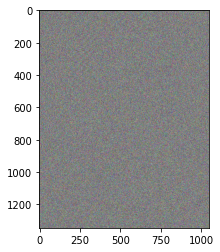

In [ ]:
# encrypt and store the result

if os.path.exists(encrypted_CBC_dir) is not True:
    os.mkdir(encrypted_CBC_dir)
encrypted_CBC_imgs = []

for index, img in enumerate(imgs):
    encrypted = encrypt_CBC(img, Km, index)
    encrypted_CBC_imgs.append(encrypted)
    encrypted.save(os.path.join(encrypted_CBC_dir,f'0{index+1}.png'))
print("The last sample has been shown below.")

### Decryption

In [ ]:
def decrypt_CBC(img, Km, index, selfInvert=True):
    Km_inv = np.array(Matrix(Km).inv_mod(256), dtype='uint8') if not selfInvert else Km
  
     
    img = np.array(img)
    S = img.shape
    h, w , c = S[0], S[1], S[2] # img = Height * Width * Channel
    img_decrypted = np.zeros([h*w, c])
    
    # split img into blocks of size four 
    img = img.reshape(h*w, c)
    remaining = h*w % 4 # number of remaining pixels per channel
    num_block = h*w //4 # number of blocks per channel

    # decryption
    for i in range(c):
        vec = np.array(Km)[i,:].flatten()
        for block in range(num_block):
            # offset = np.squeeze(np.array(Km_inv[(i+block)%4, :]))
            offset = 0
            cipher_block = img[4*block:4*(block+1), i]
            img_decrypted[4*block: 4*(block+1), i] = (np.matmul(Km_inv, cipher_block) - vec) % 256
            vec = cipher_block
            
    img_decrypted = img_decrypted.reshape(h, w, c)
    img_decrypted = Image.fromarray(np.uint8(img_decrypted))
    
    print(f"Image0{index+1} has been decrypted successfully.")
    plt.imshow(img_decrypted)
    
    return img_decrypted     

Image01 has been decrypted successfully.
Image02 has been decrypted successfully.
Image03 has been decrypted successfully.
Image04 has been decrypted successfully.
The last sample has been shown below.


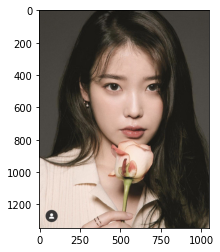

In [ ]:
# Decrypt and store the result
if os.path.exists(decrypted_CBC_dir) is not True:
    os.mkdir(decrypted_CBC_dir)

decrypted_CBC_imgs = []
    
for index, img in enumerate(encrypted_CBC_imgs):
    decrypted = decrypt_CBC(img, Km, index)
    decrypted_CBC_imgs.append(decrypted)
    decrypted.save(os.path.join(decrypted_CBC_dir,f'0{index+1}.png'))
print("The last sample has been shown below.")

### Visulization

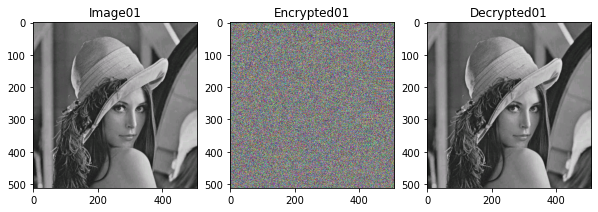

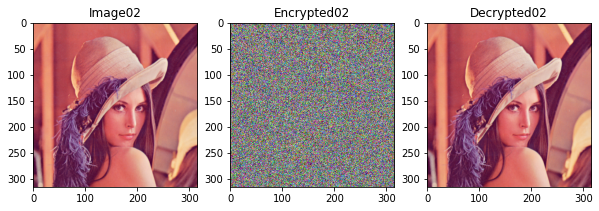

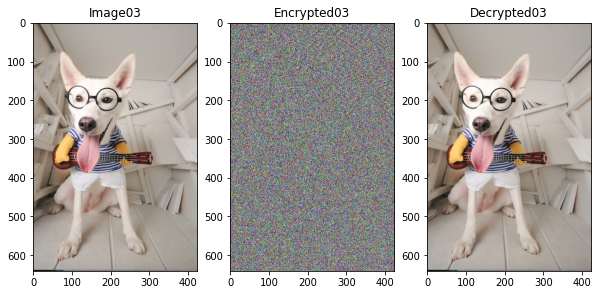

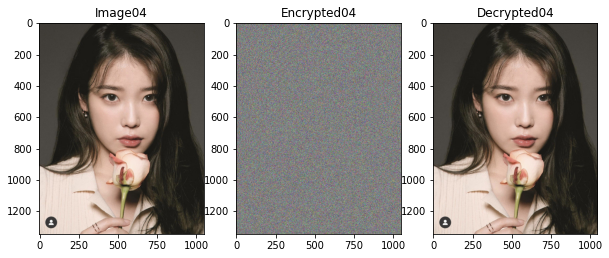

In [ ]:
visualization(imgs, encrypted_CBC_imgs, decrypted_CBC_imgs)

### Security Analysis

#### PSNR

In [ ]:
print("The PSNR between images and cipher images are as follows")
for id, name in enumerate(names):
    img_original = imgs[id]
    img_CBC_encrypted = encrypted_CBC_imgs[id]
    print(f"ID:{id+1} | Name: {name} |PSNR: %.3f" % PSNR(img_original,img_CBC_encrypted))

The PSNR between images and cipher images are as follows
ID:1 | Name: Lena_gray |PSNR: 9.040
ID:2 | Name: Lena_color |PSNR: 8.652
ID:3 | Name: Dog |PSNR: 8.981
ID:4 | Name: IU |PSNR: 7.448


#### UACI

In [ ]:
print("The UACI between images and cipher images are as follows")
for id, name in enumerate(names):
    img_original = imgs[id]
    img_CBC_encrypted = encrypted_CBC_imgs[id]
    print(f"ID:{id+1} | Name: {name} | UACI: %.3f" % UACI(img_original,img_CBC_encrypted))

The UACI between images and cipher images are as follows
ID:1 | Name: Lena_gray | UACI: 29.199
ID:2 | Name: Lena_color | UACI: 32.915
ID:3 | Name: Dog | UACI: 30.414
ID:4 | Name: IU | UACI: 35.540
